#### Notes



In [1]:
from fit2d import Galaxy, RingModel
from fit2d.mcmc import LinearPrior
from fit2d.mcmc import emcee_lnlike, piecewise_start_points
from fit2d.models import PiecewiseModel

from astropy.io import fits
import copy
from datetime import datetime
import glob
import joblib
import numpy as np
import os

import emcee
from emcee import EnsembleSampler, moves

In [2]:
num_bins = 14
# min and max bounds for each bin
vmin, vmax = 0, 200

# min and max inc, pos angle in RADIANS
inc_min, inc_max = np.radians(50), np.radians(80)
pos_angle_min, pos_angle_max = np.radians(0), np.radians(360)

name = "NGC2366"
distance = 3400. # [kpc]

home_directory = "/Users/stephencoffey/Downloads/little-things/data"
observed_2d_vel_field_fits_file = f"{home_directory}/NGC2366_1mom_cropped.fits"
# to use the dispersion as a source of errors, provide this file name
# observed_2d_dispersion_fits_file = f"{home_directory}/NGC2366_2mom.fits"
deg_per_pixel=4.17e-4

ring_param_file = f"{home_directory}/NGC2366_ring_parameters_rohit.txt"
v_systemic = 100 #changed to 100 to equal exactly what we used in mathematica

In [3]:
# x and y dims are switched in ds9 fits display versus np array shape
fits_ydim, fits_xdim = fits.open(observed_2d_vel_field_fits_file)[0].data.shape

mask_sigma=1.
random_seed = 1234

mcmc_nwalkers = 40
mcmc_niter = 5000
mcmc_ndim = 16  # Do not change this if fitting one ring at a time
mcmc_nthreads = 40
# Try increasing stretch scale factor a. version must be >=3 for this to be used.
mcmc_moves = moves.StretchMove(a = 2)
mcmc_version = float(emcee.__version__[0])

# Option to save every batch_size iterations in case of crash<br>
# Increase this; 2 is a very low value just for testing

batch_size = 50

# option to save outputs in a particular directory
save_dir = "/Users/stephencoffey/Downloads/little-things/mcmc_pickles/14bins/"

In [4]:
galaxy = Galaxy(
    name=name,
    distance=distance,
    observed_2d_vel_field_fits_file=observed_2d_vel_field_fits_file,
    deg_per_pixel=deg_per_pixel,
    v_systemic=v_systemic
)

In [5]:
ring_model = RingModel(
    ring_param_file=ring_param_file,
    fits_xdim=fits_xdim,
    fits_ydim=fits_ydim,
    distance=distance
)

ring_param_bounds = [(vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (vmin, vmax), (inc_min, inc_max), (pos_angle_min, pos_angle_max)]




In [6]:
fit_structural_params = {"inc": -2, "pos_angle": -1}

In [7]:
vels, incs, pos_angles = np.loadtxt(ring_param_file, usecols=(2, 4, 5)).T
v_rot = []
bin_indices1 = np.linspace(0, len(ring_model.radii_kpc_interp)/2 - 1, num_bins - 3)
bin_indices2 = np.linspace(len(ring_model.radii_kpc_interp)/2, len(ring_model.radii_kpc_interp)-2, 3)
bin_indices = np.concatenate((bin_indices1, bin_indices2))

bin_edges = []
for i in bin_indices:
    bin_edges.append(ring_model.radii_kpc_interp[int(i)])
bin_edges.append(ring_model.radii_kpc_interp[-1])
for i in range(num_bins-1):
    v_rot.append(np.mean(vels[int(bin_indices[i]):int(bin_indices[i+1])]))
print(bin_edges)
print("vrot", v_rot)

[0.09890199094634534, 0.4945099547317267, 1.0879219004097989, 1.4835298641951802, 2.076941809873252, 2.670353755551324, 3.0659617193367055, 3.6593736650147775, 4.252785610692849, 4.648393574478231, 5.241805520156303, 5.439609502048993, 8.011061266653966, 10.582513031258939, 10000.0]
vrot [9.366, 14.776000000000002, 24.734, 35.984, 41.67766666666667, 47.738, 52.359, 52.12833333333333, 52.195499999999996, 54.423, 53.377, nan, nan]


/Users/stephencoffey/anaconda2/envs/anna_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/stephencoffey/anaconda2/envs/anna_env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
v_err_const = 10. # [km/s] constant error per pixel
v_err_2d = None
#v_err_2d = galaxy.observed_2d_dispersion

In [9]:
import warnings
warnings.simplefilter('ignore')
from joblib import Parallel, delayed
from fit2d._velocity_field_generator import create_2d_velocity_field

inc = np.radians(60)  # fill this in with something within the priors
pos_angle = np.radians(40) # fill this in with something within the priors

# if inc and/or pos_angle are not being fit in the MCMC, they will be fixed to constant values inc_fake, pos_angle_fake

ring_model.update_structural_parameters(inc=inc, pos_angle=pos_angle)

In [10]:
from fit2d.mcmc._likelihood import chisq_2d, lnlike
import matplotlib.pyplot as plt

bin_min, bin_max = bin_edges[0], bin_edges[-1]

galaxy.observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data
mask = np.nan_to_num(galaxy.observed_2d_vel_field/galaxy.observed_2d_vel_field, nan=0.)

dimensions = galaxy.observed_2d_vel_field.shape

piecewise_model = PiecewiseModel(num_bins=num_bins)
piecewise_model.set_bounds(array_bounds=ring_param_bounds)
#piecewise_model.set_bin_edges(rmin=bin_min, rmax=bin_max)
piecewise_model.bin_edges = bin_edges
radii_to_interpolate = np.array([r for r in ring_model.radii_kpc_interp if bin_min<=r<=bin_max])

prior = LinearPrior(bounds=piecewise_model.bounds)
prior_transform = prior.transform_from_unit_cube

# instead of using piecewise_model.bounds, we've manually input bounds for the starting positions so the walkers start out much closer to the value we're looking for
start_positions = piecewise_start_points(mcmc_nwalkers, bounds = [(9,11), (16,18), (24, 26), (29, 31), (39, 41), (44, 46), (49, 51), (51, 53), (52, 54), (52, 54), (52, 54), (52, 54), (52, 54), (52, 54), (inc - 0.1, inc + 0.1), (pos_angle - 0.1, pos_angle + 0.1)], random_seed=random_seed)
fit_inputs = {
    "piecewise_model": piecewise_model,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "prior_transform": prior_transform
}

rotation_curve_func_kwargs = {
    "radii_to_interpolate": radii_to_interpolate}
lnlike_args = {
    "model": piecewise_model,
    "rotation_curve_func_kwargs": rotation_curve_func_kwargs,
    "galaxy": galaxy,
    "ring_model": ring_model,
    "mask_sigma": mask_sigma,
    "v_err_const": v_err_const,
    "v_err_2d": v_err_2d,
    "fit_structural_params": fit_structural_params
}

sampler = EnsembleSampler(
    mcmc_nwalkers,
    mcmc_ndim,
    emcee_lnlike,
    args=[mcmc_version, lnlike_args],
    threads=mcmc_nthreads,
)
if mcmc_version >= 3:
    sampler._moves = [mcmc_moves]
sampler_output_file = os.path.join(
    save_dir or "", f"sampler_{galaxy.name}_{mcmc_niter}iter.pkl")

In [11]:
for batch in range(mcmc_niter // batch_size):
    if batch == 0:
        batch_start = start_positions
    else:
        batch_start = None
        sampler.pool = temp_pool
    sampler.run_mcmc(batch_start, batch_size)
    temp_pool = sampler.pool
    del sampler.pool
    with open(sampler_output_file, 'wb') as f:
        sampler_copy = copy.copy(sampler)
        del sampler_copy.log_prob_fn
        joblib.dump(sampler_copy, f)

    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_niter}")

Done with steps 0 - 50 out of 5000
Done with steps 50 - 100 out of 5000
Done with steps 100 - 150 out of 5000
Done with steps 150 - 200 out of 5000
Done with steps 200 - 250 out of 5000
Done with steps 250 - 300 out of 5000
Done with steps 300 - 350 out of 5000
Done with steps 350 - 400 out of 5000
Done with steps 400 - 450 out of 5000
Done with steps 450 - 500 out of 5000
Done with steps 500 - 550 out of 5000
Done with steps 550 - 600 out of 5000
Done with steps 600 - 650 out of 5000
Done with steps 650 - 700 out of 5000
Done with steps 700 - 750 out of 5000
Done with steps 750 - 800 out of 5000
Done with steps 800 - 850 out of 5000
Done with steps 850 - 900 out of 5000
Done with steps 900 - 950 out of 5000
Done with steps 950 - 1000 out of 5000
Done with steps 1000 - 1050 out of 5000
Done with steps 1050 - 1100 out of 5000
Done with steps 1100 - 1150 out of 5000
Done with steps 1150 - 1200 out of 5000
Done with steps 1200 - 1250 out of 5000
Done with steps 1250 - 1300 out of 5000
Don

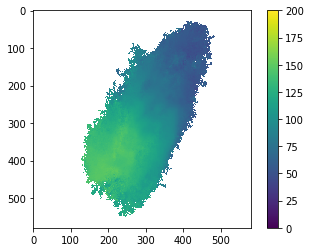

In [13]:
import matplotlib.pyplot as plt

plt.imshow(galaxy.observed_2d_vel_field, vmin = 0, vmax = 200)
plt.colorbar()

In [11]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
%matplotlib notebook

# loads pickle and grabs single walker path (we chose the 0th)
def loadpkl(num_bins, path):
    d = {}
    with open(f'{path}/sampler_{name}_{mcmc_niter}iter.pkl', 'rb') as f:
        d[f'saved_sampler_{name}'] = joblib.load(f)
    return d
def grab_walker(w, num_bins, path):
    d = loadpkl(num_bins, path)
    for sampler in d.values():
        nwalkers, niter, nparams = sampler.chain.shape   
    walker = np.array(sampler.chain[w,:,:]) # one walker path
    vels, incs, pas = walker[:,w:num_bins], walker[:,num_bins], walker[:,num_bins+1]
    return vels, incs, pas
mask = galaxy.observed_2d_vel_field/galaxy.observed_2d_vel_field


fig, ax = plt.subplots()
ax.imshow(galaxy.observed_2d_vel_field, cmap = 'gray') # plotting data underneath, just for comparison

# creating the static colorbar w/o mappable object
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=200)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', label='vel')

# generates model fields using param vals from each step in chain
ims = []
for w in range(mcmc_nwalkers):
    for i in range(mcmc_niter - 100, mcmc_niter):
        vels, incs, pas = grab_walker(w, 14, f"{save_dir}")

        model = create_2d_velocity_field(
            radii = piecewise_model.generate_1d_rotation_curve(vels[i], **rotation_curve_func_kwargs)[0],
            v_rot = piecewise_model.generate_1d_rotation_curve(vels[i], **rotation_curve_func_kwargs)[1],
            i = incs[i],
            pa = pas[i],
            v_sys = galaxy.v_systemic,
            x_dim = galaxy.image_xdim,
            y_dim = galaxy.image_ydim,
            x_center = fits_xdim/2,
            y_center = fits_ydim/2,
            kpc_per_pixel = galaxy.kpc_per_pixel
            )
        im = mask*model
        #im = ax.imshow(mask*model, cmap = cmap)
        ims.append([im])

avg_model = np.sum(ims) / 100

plt.imshow(avg_model)
plt.colorbar()
        
        
"""
# runs the animation
anim = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()

# saves animation
f = f"{save_dir}modelmaps.gif" 
writergif = animation.PillowWriter(fps=30) 
anim.save(f, writer=writergif)"""

<IPython.core.display.Javascript object>

IndexError: index 13 is out of bounds for axis 0 with size 13

In [ ]:
def loadpkl(num_bins, path):
    d = {}
    with open(f'{path}/sampler_{name}.pkl', 'rb') as f:
        d[f'saved_sampler_{name}'] = joblib.load(f)
    return d

def grab_walker(num_bins, path):
    d = loadpkl(num_bins, path)
    for sampler in d.values():
        nwalkers, niter, nparams = sampler.chain.shape
        
    walker = np.array(sampler.chain[0,:,:]) # one walker path
    vels, incs, pas = walker[:,0:num_bins], walker[:,num_bins], walker[:,num_bins+1]

    return vels, incs, pas

vels, incs, pas = grab_walker(10, "/Users/stephencoffey/Downloads/little-things/notebooks/stephen/newest/")
mask = galaxy.observed_2d_vel_field/galaxy.observed_2d_vel_field
last_bin = create_2d_velocity_field(
        radii = bin_edges[:-1],
        v_rot = [vels[100][i] for i in range(len(bin_edges)-1)],
        i = incs[100],
        pa = pas[100],
        v_sys = galaxy.v_systemic,
        x_dim = galaxy.image_xdim,
        y_dim = galaxy.image_ydim,
        x_center = fits_xdim/2,
        y_center = fits_ydim/2,
        kpc_per_pixel = galaxy.kpc_per_pixel
        )

plt.imshow(last_bin)

In [ ]:
plt.imshow(ims[400])
plt.colorbar()

In [ ]:
plt.imshow(ims[0])
plt.colorbar()

In [ ]:
"""import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()"""

In [ ]:
print(f"Done with emcee fit for {galaxy.name}")

In [ ]:
"""log_probs = sampler.get_log_prob()
print("log prob of best fit point:", np.amax(log_probs))
log_max = np.where(log_probs == np.amax(log_probs))
param_vals = sampler.get_chain()[log_max]
print("vel, inc, vsini of best fit point:", (param_vals[0][0], param_vals[0][1],param_vals[0][0]*np.sin(param_vals[0][1]) ))
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
#print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time())))"""